# **`SVM` Model (Notebook version) for `CAPTCHA` recognition**


---


Based on Ethan Chen's `CNN` model Notebook

Lijiangnan Tian (lijiangn@ualberta.ca)


---


## **1) Data Preprocessing**
Import the libraries

In [ ]:
import os
import cv2
import torch
import string
import random
import pathlib
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cpu


In [ ]:
# Parameters:
NUMBER = ["{}".format(x) for x in range(10)]
ALPHABET = list(string.ascii_uppercase)
TABLE = NUMBER + ALPHABET # The table for CAPTCHA
LEN_OF_TABLE = len(TABLE) # in total 10+26 alphanumeric characters
BATCH_SIZE = 100
LEN_OF_CAPTCHA = 6 # each picture contains 6 characters
LEARNING_RATE = 0.001 # η
print("Number of alphanumeric characters:", LEN_OF_TABLE)

Number of alphanumeric characters: 36


Load the dataset, please modify the path `data_dir` **accordingly**

In [ ]:
# Load the dataset from my Google Drive
from google.colab import drive
drive.mount('/gdrive')
data_dir = pathlib.Path("/gdrive/My Drive/Data/")

# Path to the local dataset
# data_dir = pathlib.Path("./dataset")

images = list(data_dir.glob("*.jpg")) # dataset as a list
print("Number of images found:", len(images)) # size of the dataset

Mounted at /gdrive
Number of images found: 10000


The `CAPTCHA` samples in the dataset

Shape of CAPTCHA image: (50, 200, 3)
Shape of CAPTCHA image: (50, 200, 3)
Shape of CAPTCHA image: (50, 200, 3)
Shape of CAPTCHA image: (50, 200, 3)
Shape of CAPTCHA image: (50, 200, 3)
Shape of CAPTCHA image: (50, 200, 3)


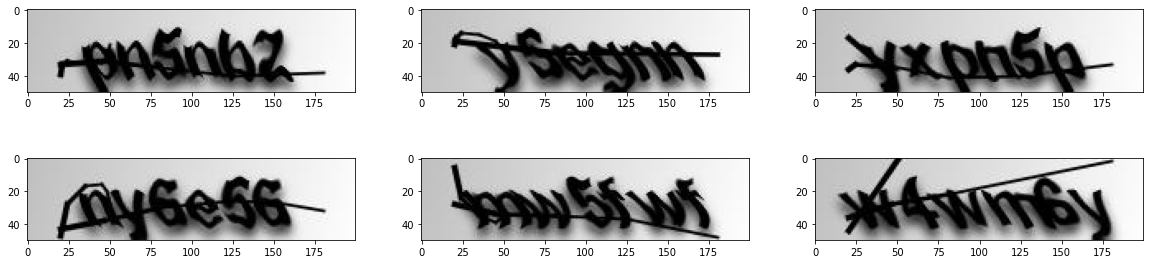

In [ ]:
sample_images =images[:6] 
_, ax = plt.subplots(2, 3, figsize=(20, 5))
for i in range(6):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of CAPTCHA image:", img.shape)
    ax[i//3, i % 3].imshow(img)
plt.show()

### Customise the dataset class

In [ ]:
# Convert the CAPTCHA into the (6*36,) vector (6 characters, 10 numbers + 26 uppercase/capital characters)
# 1 means the CAPTCHA image contains this character in TABLE, 0 means otherwise
def captcha_to_vector(captcha_str):
    captcha_str = captcha_str.upper()
    vector = np.zeros(36*6, dtype=np.float32)
    for i, char in enumerate(captcha_str):
        ascii = ord(char) # Convert char into ASCII code
        if 48 <= ascii <= 57:   # for digits
            index = ascii - 48
        elif 65 <= ascii <= 90: # for Latin letters
            index = ascii - ord('A') + 10
        vector[i*LEN_OF_TABLE+index] = 1.0
    return vector
# Convert the vector to the CAPTCHA (the input vector is different from the vector above)
# example: 
#   input:  [1,2,34,2,6,7] 
#   output: "23Y378"
def vector_to_captcha(vector):
    captcha_str = ""
    for i in vector:
        captcha_str += TABLE[i]
    return captcha_str
# Custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None, target_transform=None, height=50, width=200):
        self.transform = transform
        self.target_transform = target_transform
        self.images = images
        self.width = width
        self.height = height

    def __getitem__(self, index):
        # get the image with path
        image = cv2.imread(str(self.images[index]))
        # increase contrast: segmentation-based so the preprocessing is more complicated
        image = cv2.convertScaleAbs(image, alpha=3, beta=40)
        # Erode noise
        kernel = np.ones((1, 1), np.uint8)
        image = cv2.erode(image, kernel, iterations=1)
        # convert the image into grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
        # resize the image to ensure the size
        image = cv2.resize(image, (self.width, self.height))
        # Binarization of images
        _, image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
        # Method from dsp.stackexchange.com/questions/52089/removing-noisy-lines-from-image-opencv-python
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        # Shear transformation, from thepythoncode.com/article/image-transformations-using-opencv-in-python#Image_Shearing
        M = np.float32([[1, -0.5, 0],
             	          [0,    1, 0],
            	          [0,    0, 1]])
        rows, cols = image.shape #(50, 200)
        image = cv2.warpPerspective(image,M,(int(cols),int(rows)), cv2.INTER_LINEAR, borderValue=(255, 255, 255))
        # horizontal stretch
        M = np.float32([[1.2, 0, 0],
             	          [0,   1, 0],
            	          [0,   0, 1]])
        rows, cols = image.shape #(50, 200)
        image = cv2.warpPerspective(image,M,(int(cols),int(rows)), cv2.INTER_LINEAR, borderValue=(255, 255, 255))

        label = captcha_to_vector(self.images[index].name.split("_")[0])
        img_seg_list = []
        label_lst = []
        # segmentation [image[:,:50], image[:,50:75], image[:,75:100], image[:,100:125], image[:,125:150], image[:,150:]]
        for j in range(LEN_OF_CAPTCHA):
          #if j==0: left = 0#else: 
          left = (j+1)*25
          #if j==LEN_OF_CAPTCHA-1: right = 200#else: 
          right = (j+2)*25
          im_seg = image[:, left:right]
          # Apply the transform to the image
          if self.transform is not None:
            img_seg_list.append(self.transform(im_seg))
          else:
            img_seg_list.append(im_seg)
          label_lst.append(label[j*36:(j+1)*36])
        # Apply the transform to the image
        #if self.transform is not None:
            #image = self.transform(image)
        return img_seg_list, label_lst

    def __len__(self):
        return len(self.images)

### Split and create datasets

In [ ]:
random.shuffle(images)
NUMBER_Images = len(images)
# test data
test_data = images[int(0.8*NUMBER_Images):]     # last 2k images (20%) in dataset are for testing

# the part for training
training = images[:int(0.8*NUMBER_Images)]      # first 8k (80%) images in dataset are for training
train_data = training
#valid_data = training[int(0.6*NUMBER_Images):]  # last 2k images in the training set are for validation
#train_data = training[:int(0.6*NUMBER_Images)]  # 6k images for training

print('\033[1m') # boldface
print("Training set size:\t", len(train_data))
#print("Validation set size:\t", len(valid_data))
print("Test set size:\t\t", len(test_data))
print('\033[0m')

train_set = CustomDataset(train_data, transform=transforms.ToTensor())
#valid_set = CustomDataset(valid_data, transform=transforms.ToTensor())
test_set  = CustomDataset(test_data,  transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)#BATCH_SIZE
#valid_dataloader = DataLoader(dataset=valid_set, batch_size=1, shuffle=True)
test_dataloader  = DataLoader(dataset=test_set,  batch_size=1, shuffle=True)


Training set size:	 8000
Test set size:		 2000



## **Sample preprocessed `CAPTCHA` images**
After improvement by **preprocessing** (Original $\to$ Erosion $\to$ Grayscale $\to$ Binarization $\to$ Morph $\to$ Shear $\to$ Stretch $\to$ Segmentation)

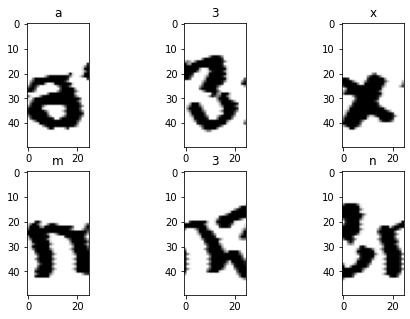

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(8, 5))
for x in range(1):
    i, l = next(iter(test_dataloader))
    print
    for image, label in zip(i, l):
      image = image.to(device)
      label = label.to(device)
      # output = model(image)
      label = label.reshape(1, 36)
      # output = output.reshape(6, 36)
      label = torch.argmax(label, dim=1)
      # output = torch.argmax(output, dim=1)
      origin = vector_to_captcha(label).lower()
      #origin = (label[0]).lower()
      # predict = vector_to_captcha(output)

      image = image.reshape(image.shape[2], image.shape[3]).cpu()
      #image = image.reshape(50, 200).cpu()
      ax[x // 3, x % 3].imshow(image, cmap=plt.cm.gray)
      ax[x // 3, x % 3].title.set_text(origin)
      x+=1
plt.show()

## **2) `SVM` Model** ($\in$ segmentation-based algorithms)

In [ ]:
def get_data(dataloader):
  X = []
  Y = []
  n = len(dataloader)
  for z in range(n):
    print("\b\b\b\b\b{}".format(z+1), end="")
    i, l = next(iter(dataloader))
    for image, label in zip(i, l):
      image = image.to(device)
      label = label.to(device)
      label = label.reshape(1, 36)
      label = torch.argmax(label, dim=1)
      label = vector_to_captcha(label)
      image = image.reshape(image.shape[2], image.shape[3]).cpu()
      X.append(image.flatten().tolist())
      Y.append(label)#.tolist())
  print("")
  new_Y = []
  for j in range(len(Y)):
    new_Y.append(Y[j][0])
  return X, Y

**Training the support vector machine**

In [ ]:
# Code in this cell is from kaggle.com/sanesanyo/digit-recognition-using-svm-with-98-accuracy
# Splitting the data into test and training set for our first simple linear SVM testing
#from sklearn.model_selection import train_test_split
#train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
# Creating our linear SVM object
from sklearn.svm import SVC
clf=SVC(C=1,kernel="linear")
train_x,train_y = get_data(train_dataloader)
clf.fit(train_x, train_y)

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Use the **`SVM`** to recognise new `CAPTCHA`

In [ ]:
# Groups the original and the predicted characters together to into CAPTCHAs
def group(lst):
  n = len(lst)
  i = 0
  new_list = []
  while i < n:
    captcha = lst[i:i+5]
    new_list.append(''.join(captcha))
    i += 6
  return new_list
# code for prediction and accuracy modified fromthe same Kaggle source
# Saving the predictions on the test set 
test_x,test_y = get_data(test_dataloader)
y_predict = clf.predict(test_x)
# group the original and the predicted characters together to a CAPTCHA
test_y = group(test_y)
y_predict = group(y_predict)
# Measuring the accuracy of our predictions
from sklearn import metrics
accuracy=metrics.accuracy_score(test_y,y_predict)
print("Accuracy: {}%".format(accuracy*100))

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138

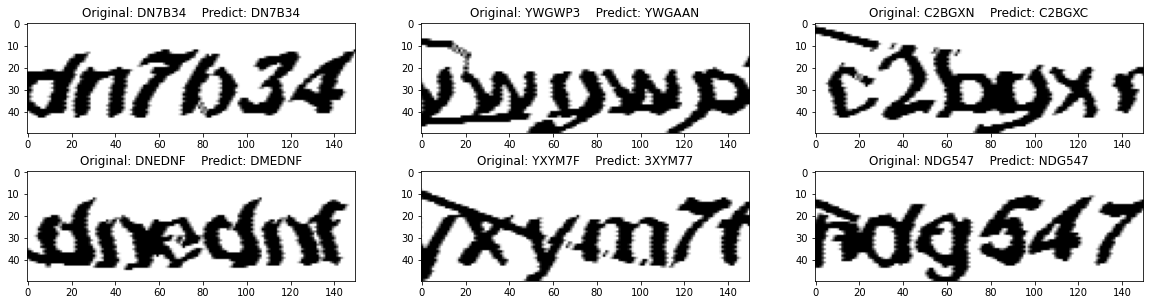

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(20, 5))
for p in range(6):
    i, l = next(iter(test_dataloader))
    img = np.zeros((50,150))
    j = 0
    predicts = []
    origins = []
    for image, label in zip(i, l):
        image = image.to(device)
        image = image.reshape(1,image.shape[2]* image.shape[3]).cpu()
        predict = clf.predict(image)
        #predict = vector_to_captcha(int(predict)).lower()
        predicts.append(predict[0])
        img[:,j:j+25] = image.reshape(50,25)
        j += 25
        label = label.to(device)
        label = label.reshape(1, 36)
        label = torch.argmax(label, dim=1)
        origin = vector_to_captcha(label)
        origins.append(origin)
    ax[p // 3, p % 3].imshow(img,cmap=plt.cm.gray)
    ax[p // 3, p % 3].title.set_text("Original: "+"".join(origins)+"    Predict: "+"".join(predicts))
plt.show()